In [6]:
import numpy as np
data=np.genfromtxt("/home/limu/Space/data/atti/vzlusat2_aocs1.csv",delimiter=',',skip_header=1).T

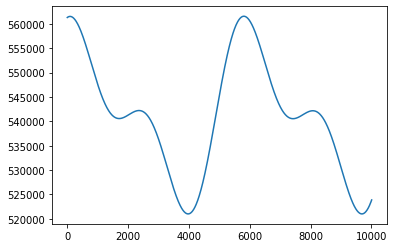

In [9]:
from matplotlib import pyplot as pl
%matplotlib inline

tim=data[0]-data[0][0]
pl.plot(tim,data[-1])

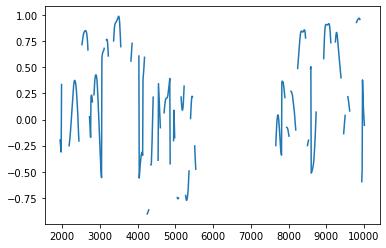

In [10]:
pl.plot(tim,data[1])

(3000.0, 4300.0)

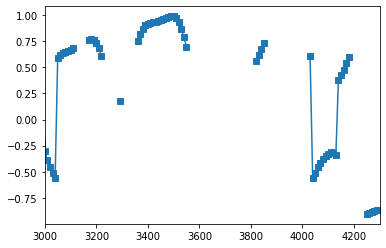

In [160]:
pl.plot(tim,data[1],'s-')
pl.xlim(3000,4300)

In [166]:
mat100=[]
idx100=[]
for k in range(300,430):
    if data[1,k]==np.nan: continue
    try:
        mat100.append(spt.Rotation.from_quat(data[1:5,k]).as_matrix())
    except:
        continue
    idx100.append(k)
matsel=np.array(mat100)
len(idx100)

64

In [167]:
timsel=tim[idx100]
matsel.shape

(64, 3, 3)

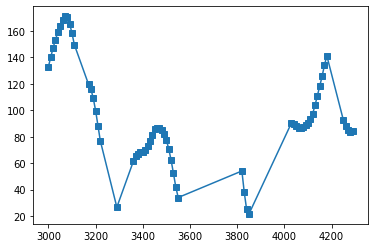

In [171]:
ang_zp_fly=np.rad2deg(np.arccos(matsel[:,2,0]))
pl.plot(timsel,ang_zp_fly,'s-')

In [165]:
matsel=np.array([spt.Rotation.from_quat(data[1:5,k]).as_matrix() for k in range(300,430)  if data[1,k]!=np.nan])

ValueError: Found zero norm quaternions in `quat`.

In [13]:
np.isnan(data[1]).sum(),data[1].shape

(643, (1001,))

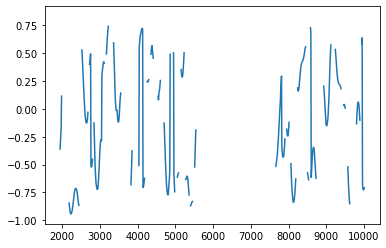

In [14]:
pl.plot(tim,data[4])

In [17]:
from scipy.spatial import transform as spt

In [36]:
agood=np.where(np.isnan(data[1])==False)[0]
jind=1
b2lv=spt.Rotation.from_quat(data[1:5,agood[jind]])

In [32]:
#b2lv.as_euler("xyx")
b2lv.as_matrix()

array([[-0.71207721,  0.23847869,  0.66035896],
       [ 0.58760708,  0.71720066,  0.37462131],
       [-0.38427068,  0.6547909 , -0.65083402]])

In [30]:
sv=b2lv.as_rotvec()

array([0.62547202, 2.3321111 , 0.77942092])

In [33]:
b2lv.apply([0,0,-1])

array([-0.66035896, -0.37462131,  0.65083402])

In [131]:
pos=data[-5:,agood[jind]]
pos[0]

34.38236058384723

In [132]:
import astropy.coordinates as coor
import astropy.units as u
inter=coor.EarthLocation(lon=pos[1]*u.deg,lat=pos[0]*u.deg)
satel=coor.EarthLocation(lon=pos[3]*u.deg,lat=pos[2]*u.deg,height=pos[4]*u.m)

In [133]:
eloc2cart=lambda k: np.array([k.x.value,k.y.value,k.z.value])
cart2angle=lambda p:[np.rad2deg(np.arcsin(p[2])),np.rad2deg(np.arctan2(p[1],p[0]))]
norm=lambda v:np.sqrt(np.dot(v,v))

look=eloc2cart(satel)-eloc2cart(inter)
#coor.SkyCoord(*[l*u.km for l in look]) x=look[0],y=look[1],z=look[2]
dec,ra=cart2angle(look/norm(look))
alook=coor.SkyCoord(ra,dec,frame='icrs',unit='deg')#[l*u.m for l in look],representation_type='cartesian', frame="icrs")
alook.location=satel
alook.obstime=x
alook.altaz

<SkyCoord (AltAz: obstime=2022-05-20 22:02:53, location=(4934350.49877974, 2073098.9920879, 4371651.17911943) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (3.64282836, 34.31860327)>

In [100]:
from datetime import datetime
x=datetime.fromtimestamp(data[0,agood[jind]])

In [101]:
alook.location=satel
alook.obstime=x
alook.altaz

<SkyCoord (AltAz: obstime=2022-05-20 22:02:53, location=(4930490.86188263, 4052244.23310898, 2664778.51862992) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (336.84758429, -48.59502226)>

In [78]:
import predict
qth=list(pos[:2])+[0]
tle='''VZLUSAT2
1 51085U 22002BF  22150.70473102  .00004963  00000-0  28884-3 0  9994
2 51085  97.4865 217.8168 0015989 133.4617 325.2380 15.12382761 20719'''
mypos=predict.observe(tle, qth, at=data[0,agood[jind]])
#eloc2cart(satel)

In [134]:
eloc2cart(satel)

array([4934350.49877974, 2073098.9920879 , 4371651.17911943])

In [120]:
satel.to_geodetic()

GeodeticLocation(lon=<Longitude 39.41590996 deg>, lat=<Latitude 22.78903621 deg>, height=<Quantity 541079.76815077 m>)

In [125]:
pos2=[mypos[a] for a in ['longitude','latitude','altitude']]
satpos2=coor.EarthLocation.from_geodetic(lon=pos2[0]*u.deg,lat=pos2[1]*u.deg,height=pos2[2]*u.km)

In [129]:
pos2

[22.81029062489508, 39.33950650438123, 541.6336487902554]

In [128]:
satpos2.to_geodetic()

GeodeticLocation(lon=<Longitude 22.81029062 deg>, lat=<Latitude 39.3395065 deg>, height=<Quantity 541.63364879 km>)

In [117]:
def get_fly(time,satpos=None):
    mypos=predict.observe(tle, qth, at=time.timestamp())
    pos=[mypos[a] for a in ['longitude','latitude','altitude']]
    fly=np.array([mypos['eci_v'+a] for a in list('xyz')])
    flsp=norm(fly)
    vdec,vra=cart2angle(fly/flsp)
    if satpos==None: satpos=coor.EarthLocation(lon=pos[0]*u.deg,lat=pos[1]*u.deg,height=pos[2]*u.km)
    sfly=coor.SkyCoord(vra*u.deg,vdec*u.deg,frame='icrs',location=satpos,obstime=time)
    return sfly.altaz

In [137]:
get_fly(x,satel)

<SkyCoord (AltAz: obstime=2022-05-20 22:02:53, location=(4934350.49877974, 2073098.9920879, 4371651.17911943) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (9.38721932, 0.14180257)>

In [138]:
#fly vector 100 seconds later
from datetime import timedelta
get_fly(x+timedelta(0,100))

<SkyCoord (AltAz: obstime=2022-05-20 22:04:33, location=(4535.52956209, 1731.02899368, 4916.3635766) km, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (10.74099989, 0.1373337)>

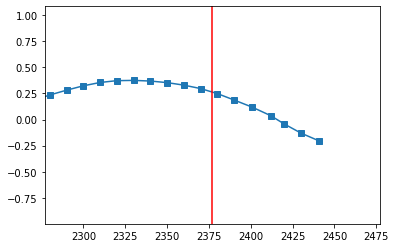

In [151]:
z0=datetime(2022, 5, 20, 22, 10, 0).timestamp()
dz=z0-data[0][0]
pl.plot(tim,data[1],'s-')
pl.xlim(dz-100,dz+100)
pl.axvline(dz,color='r')

In [159]:
j=sum(data[0]<z0)
b2lv=spt.Rotation.from_quat(data[1:5,j]).as_matrix()
b2lv

array([[ 0.18113464, -0.98341701,  0.00901292],
       [ 0.77207524,  0.14787252,  0.61808861],
       [-0.60917162, -0.10499861,  0.78605676]])

In [157]:
fly_vec=get_fly(datetime(2022, 5, 20, 22, 10, 0))
fly_vec

<SkyCoord (AltAz: obstime=2022-05-20 22:10:00, location=(2828.84592915, 524.99931963, 6274.93065683) km, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (9.07017627, -0.88196271)>